In [3]:
import pandas as pd
import numpy as np

In [4]:
a = pd.read_csv('hw_3_no_markup_data.txt', sep='\t')
a.dropna(inplace=True)

In [5]:
a

,downloadUrl
0,https://new-projects-team-public.s3.yandex.net...
1,https://new-projects-team-public.s3.yandex.net...
2,https://new-projects-team-public.s3.yandex.net...
3,https://new-projects-team-public.s3.yandex.net...
4,https://new-projects-team-public.s3.yandex.net...
...,...
33039,https://new-projects-team-public.s3.yandex.net...
33040,https://new-projects-team-public.s3.yandex.net...
33041,https://new-projects-team-public.s3.yandex.net...
33042,https://new-projects-team-public.s3.yandex.net...


In [6]:
sample = a.loc[np.random.choice(a.index, size=5_000)]
# sample = a

In [7]:
%pip install nest_asyncio

In [30]:
image_data = [{'downloadUrl': row['downloadUrl']} for _, row in sample.iterrows()]

In [31]:
import os
import requests
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import shutil
import nest_asyncio

nest_asyncio.apply()

import os
import aiohttp
import asyncio
import pandas as pd

# Создаем папку для загрузок
SAVE_DIR = "downloaded_images"
os.makedirs(SAVE_DIR, exist_ok=True)

# Функция для асинхронного скачивания одного изображения
async def download_image_async(session, url, save_dir=SAVE_DIR):
    local_filename = os.path.join(save_dir, os.path.basename(url))
    try:
        async with session.get(url) as response:
            if response.status == 200:
                with open(local_filename, 'wb') as f:
                    while True:
                        chunk = await response.content.read(1024)
                        if not chunk:
                            break
                        f.write(chunk)
                return local_filename
            else:
                print(f"Ошибка скачивания {url}: статус {response.status}")
                return None
    except Exception as e:
        print(f"Ошибка скачивания {url}: {e}")
        return None

# Функция для скачивания всех изображений
async def download_all_images(image_data):
    async with aiohttp.ClientSession() as session:
        tasks = [
            download_image_async(session, data["downloadUrl"])
            for data in image_data
        ]
        results = await asyncio.gather(*tasks)
        for i, result in enumerate(results):
            image_data[i]["path"] = result

In [32]:
asyncio.run(download_all_images(image_data))

In [36]:
from PIL import Image
import numpy as np
from collections import Counter


# Функция для извлечения признаков изображения
def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB")  # Открываем и конвертируем в RGB
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return np.zeros(10 + 3 * 256)  # Возврат массива нулей фиксированного размера

    # Приводим изображение к фиксированному размеру (для усреднения пикселей)
    fixed_size = (128, 128)
    resized_image = image.resize(fixed_size)

    # Размеры изображения
    width, height = image.size
    aspect_ratio = width / height

    # Цветовая гистограмма (256 бинов на канал)
    histogram = []
    for channel in range(3):  # R, G, B
        hist, _ = np.histogram(np.array(image)[:, :, channel], bins=256, range=(0, 256))
        histogram.extend(hist / hist.sum())  # Нормализуем гистограмму

    # print(len(histogram))

    # Средний цвет и стандартное отклонение
    mean_color = np.array(resized_image).mean(axis=(0, 1))  # Средний цвет по каждому каналу
    color_std = np.array(resized_image).std(axis=(0, 1))   # Стандартное отклонение цвета

    # Доминирующий цвет (на основе уменьшенного изображения)
    pixels = np.array(resized_image).reshape(-1, 3)  # Уменьшаем до фиксированного количества пикселей
    dominant_color = Counter(map(tuple, pixels)).most_common(1)[0][0]

    # print([width, height, aspect_ratio])
    # print(mean_color)
    # print(color_std)
    # print(list(dominant_color))
    # print(histogram)
    # Собираем все признаки
    features = np.hstack(
        [
          [width, height, aspect_ratio],      # Размеры и соотношение сторон
          mean_color,                        # Средний цвет
          color_std,                       # Стандартное отклонение цвета
          list(dominant_color),              # Доминирующий цвет
          histogram                          # Цветовая гистограмма
      ]
    )
    # print(len(features))
    return features


In [37]:
# Извлекаем признаки для всех изображений
features = np.array([extract_image_features(data["path"]) for data in image_data])

# Уменьшение размерности признаков (PCA)
pca = PCA(n_components=10)  # Сохраняем только 10 главных компонентов
reduced_features = pca.fit_transform(features)

# Кластеризация изображений с использованием K-Means
num_clusters = 150  # Количество кластеров
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(reduced_features)
labels = kmeans.labels_

# Привязываем кластеры к изображениям
for i, label in enumerate(labels):
    image_data[i]["cluster"] = label

# Создание папок и перемещение изображений по кластерам
for cluster_id in set(labels):
    cluster_folder = f"cluster_{cluster_id}"
    os.makedirs(cluster_folder, exist_ok=True)
    for data in image_data:
        if data["cluster"] == cluster_id:
            shutil.copy(data["path"], cluster_folder)



In [38]:
from sklearn.cluster import SpectralClustering

In [39]:
import random

In [41]:
num_clusters = 150
clustering = SpectralClustering(
    n_clusters=num_clusters,
    affinity='nearest_neighbors',
    random_state=42
).fit(reduced_features)

for i, label in enumerate(clustering.labels_):
    image_data[i]["cluster"] = label

n_per_cluster = 15
sampled_data = []
clusters = {label: [] for label in set(clustering.labels_)}

for data in image_data:
    clusters[data["cluster"]].append(data)


for cluster_id, items in clusters.items():
    if len(items) > n_per_cluster:
        sampled_data.extend(random.sample(items, n_per_cluster))
    else:
        sampled_data.extend(items)

sampled_data = sampled_data[:2500]

In [42]:
print(f"Семплировано {len(sampled_data)} изображений")
for data in sampled_data[:10]:  # Вывод первых 10 изображений
    print(data)

Семплировано 2225 изображений
{'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000EC31E2192CC84240465ECC528FEA4B40.jpg', 'path': 'downloaded_images/0101000020E6100000EC31E2192CC84240465ECC528FEA4B40.jpg', 'cluster': 0}
{'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000CF581A4999C84240A9E52ABD46D74B40.jpg', 'path': 'downloaded_images/0101000020E6100000CF581A4999C84240A9E52ABD46D74B40.jpg', 'cluster': 0}
{'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E610000045A9FCECB9C64240E6D470BF33DB4B40.jpg', 'path': 'downloaded_images/0101000020E610000045A9FCECB9C64240E6D470BF33DB4B40.jpg', 'cluster': 0}
{'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000CD446C0BEACB4240EB3D5870C6E34B40.jpg', 'path': 'downloaded_images/0101000020E6100000CD446C0BEACB4240EB3D5870C6E34B40.jpg', 'cluster': 0}
{'downloadUrl': 'https://new-p

<Axes: >

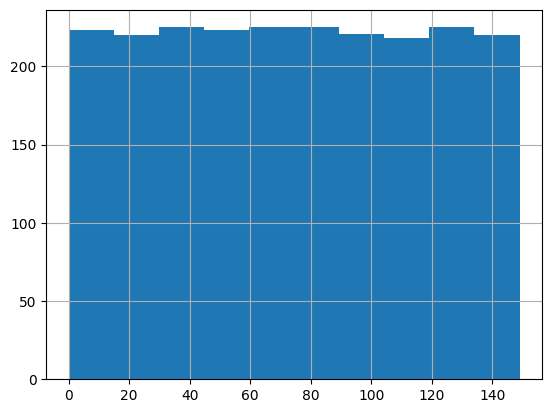

In [43]:
pd.DataFrame(sampled_data)['cluster'].hist()

In [44]:
pd.DataFrame(sampled_data).to_csv('sampled_data.csv')

In [45]:
sampled_data

[{'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000EC31E2192CC84240465ECC528FEA4B40.jpg',
  'path': 'downloaded_images/0101000020E6100000EC31E2192CC84240465ECC528FEA4B40.jpg',
  'cluster': 0},
 {'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000CF581A4999C84240A9E52ABD46D74B40.jpg',
  'path': 'downloaded_images/0101000020E6100000CF581A4999C84240A9E52ABD46D74B40.jpg',
  'cluster': 0},
 {'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E610000045A9FCECB9C64240E6D470BF33DB4B40.jpg',
  'path': 'downloaded_images/0101000020E610000045A9FCECB9C64240E6D470BF33DB4B40.jpg',
  'cluster': 0},
 {'downloadUrl': 'https://new-projects-team-public.s3.yandex.net/shad_homework_3/0101000020E6100000CD446C0BEACB4240EB3D5870C6E34B40.jpg',
  'path': 'downloaded_images/0101000020E6100000CD446C0BEACB4240EB3D5870C6E34B40.jpg',
  'cluster': 0},
 {'downloadUrl': 'https://new-projec